In [66]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
import matplotlib.gridspec as gridspec

from sklearn.model_selection import train_test_split
from collections import Counter

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE, ADASYN

from imblearn.combine import SMOTETomek
from imblearn.combine import SMOTEENN
from imblearn.metrics import classification_report_imbalanced

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_curve, roc_auc_score
from sklearn.metrics import matthews_corrcoef

import warnings
warnings.filterwarnings("ignore")

In [67]:
#loading the data
credit_card = pd.read_csv("../input/creditcard.csv")

In [68]:
#looking the how data looks
credit_card.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [69]:
#looking the type and searching for null values
credit_card.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
Time      284807 non-null float64
V1        284807 non-null float64
V2        284807 non-null float64
V3        284807 non-null float64
V4        284807 non-null float64
V5        284807 non-null float64
V6        284807 non-null float64
V7        284807 non-null float64
V8        284807 non-null float64
V9        284807 non-null float64
V10       284807 non-null float64
V11       284807 non-null float64
V12       284807 non-null float64
V13       284807 non-null float64
V14       284807 non-null float64
V15       284807 non-null float64
V16       284807 non-null float64
V17       284807 non-null float64
V18       284807 non-null float64
V19       284807 non-null float64
V20       284807 non-null float64
V21       284807 non-null float64
V22       284807 non-null float64
V23       284807 non-null float64
V24       284807 non-null float64
V25       284807 non-null float64
V26  

In [70]:
timedelta = pd.to_timedelta(credit_card['Time'], unit='s')
credit_card['Time_min'] = (timedelta.dt.components.minutes).astype(int)
credit_card['Time_hour'] = (timedelta.dt.components.hours).astype(int)

In [71]:
credit_card.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class,Time_min,Time_hour
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0,0,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0,0,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0,0,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0,0,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0,0,0


# Exploratory Data Analysis

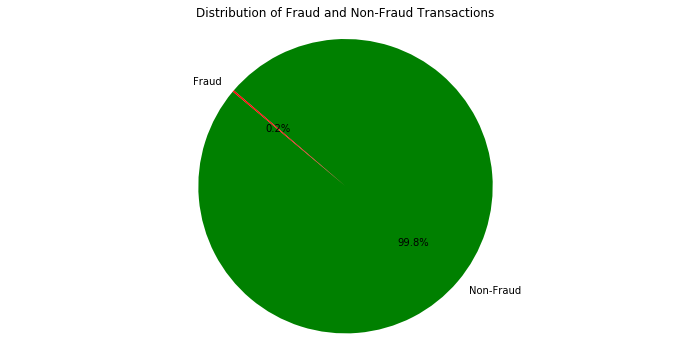

In [72]:
class_counts = credit_card['Class'].value_counts()

# Create a pie chart with green and red colors
# Set the figure size to (12, 6) inches
plt.figure(figsize=(12, 6))

# Create a pie chart with green and red colors
plt.pie(class_counts, labels=['Non-Fraud', 'Fraud'], colors=['green', 'red'], autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Fraud and Non-Fraud Transactions')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()


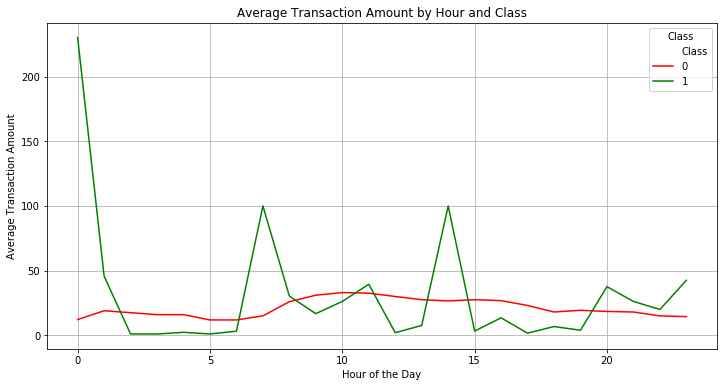

In [73]:
avg_amount_by_hour = credit_card.groupby(['Time_hour', 'Class'])['Amount'].median().reset_index()

# Plot the average amount by hour and class
plt.figure(figsize=(12, 6))
sns.lineplot(x='Time_hour', y='Amount', hue='Class', data=avg_amount_by_hour, palette={0: 'red', 1: 'green'})
plt.title('Average Transaction Amount by Hour and Class')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Transaction Amount')
plt.legend(title='Class', loc='upper right')
plt.grid(True)
plt.show()

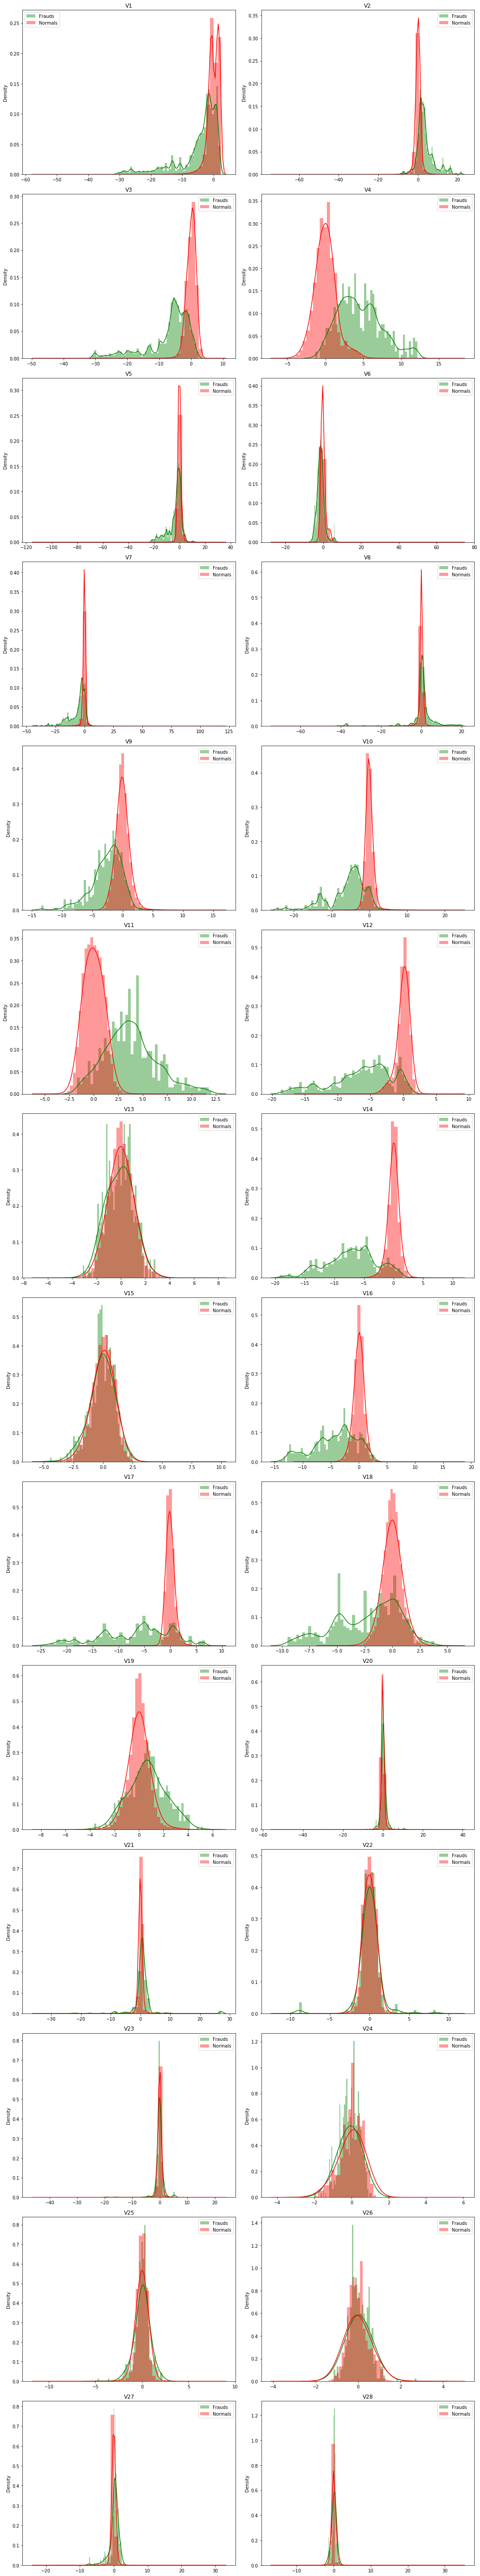

In [74]:
columns = credit_card.iloc[:,1:29].columns

frauds = credit_card.Class == 1
normals = credit_card.Class == 0

grid = gridspec.GridSpec(14, 2)
plt.figure(figsize=(15, 20*4))

colors = ['g', 'r']  # Colors for frauds and normals

for n, col in enumerate(columns):
    ax = plt.subplot(grid[n])
    sns.distplot(credit_card[col][frauds], bins=50, color=colors[0], ax=ax, label='Frauds', kde_kws={'bw': 0.5})
    sns.distplot(credit_card[col][normals], bins=50, color=colors[1], ax=ax, label='Normals', kde_kws={'bw': 0.5})
    ax.set_ylabel('Density')
    ax.set_title(col)
    ax.set_xlabel('')
    ax.legend()
plt.tight_layout()
plt.show()


# Data Preprocessing

In [75]:
#I will select the variables where fraud class have a interesting behavior and might can help us predict

credit_card = credit_card[["Time_hour", "V1","V2","V3","V4","V7","V9","V10","V11","V12","V14","V16","V17","V18","V19","Amount","Class"]]

In [76]:
credit_card.Amount = np.log(credit_card.Amount + 0.001)

In [77]:
credit_card['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [78]:

# Step 2: Split data into training and testing sets
X = credit_card.drop('Class', axis=1)
y = credit_card['Class']

In [79]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Baseline Models

In [17]:
classifiers = {
    "Random Forest": RandomForestClassifier(random_state=42, min_samples_split=2, n_estimators=10, class_weight={0: 0.80, 1: 0.20}),
    "Logistic Regression": LogisticRegression(C=11, penalty='l2', random_state=42, class_weight={0: 0.80, 1: 0.20}),
    "XGBoost": XGBClassifier(random_state=42, learning_rate=0.1, n_estimators=30, class_weight={0: 0.60, 1: 0.40}),
    "AdaBoost": AdaBoostClassifier(random_state=42, learning_rate=0.1, n_estimators=8),
    "LightGBM": LGBMClassifier(learning_rate=0.1, max_depth=3, n_estimators=50, random_state=42, class_weight={0: 0.80, 1: 0.20}),
}

In [18]:
def plot_confusion_matrix(y_true, y_pred, name, threshold):
    cm = confusion_matrix(y_true, y_pred)
    names = ['True Negatives', 'False Positives', 'False Negatives', 'True Positives']
    counts = [value for value in cm.flatten()]
    labels = [f'{v1}\n{v2}' for v1, v2 in zip(names, counts)]
    labels = np.asarray(labels).reshape(2, 2)
    cmap = sns.light_palette("#4A1A22", as_cmap=True)
    plt.figure()
    sns.heatmap(cm, annot=labels, cmap=cmap, fmt='', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
    plt.title(f'Confusion Matrix - {name} (Threshold={threshold})')
    plt.show()

### Random UnderSampling

Class distribution before RandomUnderSampler:
Counter({0: 227451, 1: 394})

Class distribution after RandomUnderSampler:
Counter({0: 394, 1: 394}) 


Algorithm: Random Forest 

Matthews Correlation Coefficient: 0.4820

Classification Report of Random Forest : 

             precision    recall  f1-score   support

          0       1.00      1.00      1.00     56864
          1       0.27      0.88      0.41        98

avg / total       1.00      1.00      1.00     56962



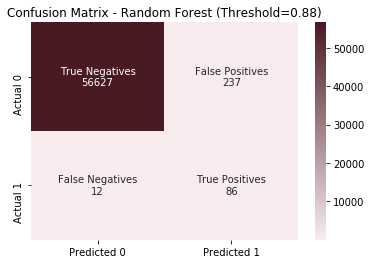


Algorithm: Logistic Regression 

Matthews Correlation Coefficient: 0.7374

Classification Report of Logistic Regression : 

             precision    recall  f1-score   support

          0       1.00      1.00      1.00     56864
          1       0.65      0.84      0.73        98

avg / total       1.00      1.00      1.00     56962



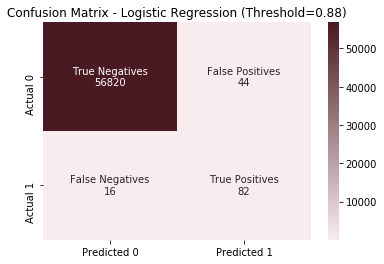


Algorithm: XGBoost 

Matthews Correlation Coefficient: 0.6981

Classification Report of XGBoost : 

             precision    recall  f1-score   support

          0       1.00      1.00      1.00     56864
          1       0.56      0.87      0.68        98

avg / total       1.00      1.00      1.00     56962



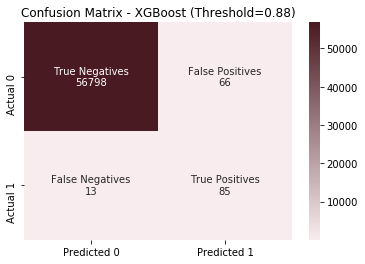


Algorithm: AdaBoost 

Matthews Correlation Coefficient: 0.3919

Classification Report of AdaBoost : 

             precision    recall  f1-score   support

          0       1.00      0.99      1.00     56864
          1       0.19      0.81      0.31        98

avg / total       1.00      0.99      1.00     56962



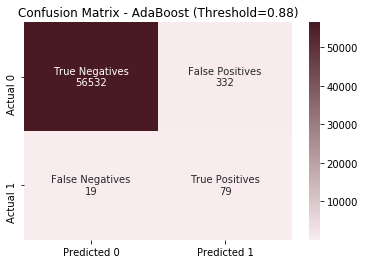


Algorithm: LightGBM 

Matthews Correlation Coefficient: 0.7140

Classification Report of LightGBM : 

             precision    recall  f1-score   support

          0       1.00      1.00      1.00     56864
          1       0.60      0.86      0.70        98

avg / total       1.00      1.00      1.00     56962



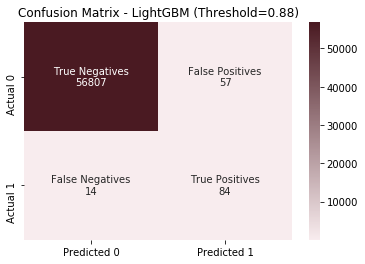

In [19]:
# Calculate class distribution before random under-sampling
print("Class distribution before RandomUnderSampler:")
print(Counter(y_train))

# Initialize RandomUnderSampler and apply it to the training data
rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

# Calculate class distribution after random under-sampling
print("\nClass distribution after RandomUnderSampler:")
print(Counter(y_resampled), '\n')

# Ensure the columns in X_test are aligned with the columns used for training
X_resampled_df = pd.DataFrame(X_resampled, columns=X_train.columns)
X_test_df = pd.DataFrame(X_test, columns=X_train.columns)

# Train and evaluate the models on the test set
for name, model in classifiers.items():
    print("\nAlgorithm:", name, '\n')
    
    # Fit the model on the entire training data after resampling
    model.fit(X_resampled_df, y_resampled)
    
    # Predict probabilities instead of classes
    y_pred_prob = model.predict_proba(X_test_df)[:, 1]  # Probabilities of positive class (fraud)

    # Adjust the threshold for binary classification
    threshold = 0.88  # Example threshold, you can change this
    y_pred = (y_pred_prob > threshold).astype(int)  # Convert probabilities to binary predictions
    
    # Compute performance metrics with the adjusted threshold
    mcc = matthews_corrcoef(y_test, y_pred)
    print(f"Matthews Correlation Coefficient: {mcc:.4f}")

    print("\nClassification Report of", name, ":", "\n")
    print(classification_report(y_test, y_pred))

    plot_confusion_matrix(y_test, y_pred, name, threshold)

Epoch 1/20
788/788 [==============================] - 1s 822us/step - loss: 2.0863 - acc: 0.4873
Epoch 2/20
788/788 [==============================] - 0s 52us/step - loss: 0.7799 - acc: 0.6815
Epoch 3/20
788/788 [==============================] - 0s 57us/step - loss: 0.5542 - acc: 0.7690
Epoch 4/20
788/788 [==============================] - 0s 55us/step - loss: 0.4612 - acc: 0.7982
Epoch 5/20
788/788 [==============================] - 0s 58us/step - loss: 0.3947 - acc: 0.8312
Epoch 6/20
788/788 [==============================] - 0s 65us/step - loss: 0.3858 - acc: 0.8414
Epoch 7/20
788/788 [==============================] - 0s 64us/step - loss: 0.3471 - acc: 0.8579
Epoch 8/20
788/788 [==============================] - 0s 63us/step - loss: 0.3400 - acc: 0.8668
Epoch 9/20
788/788 [==============================] - 0s 61us/step - loss: 0.3239 - acc: 0.8744
Epoch 10/20
788/788 [==============================] - 0s 58us/step - loss: 0.3231 - acc: 0.8731
Epoch 11/20
788/788 [=================

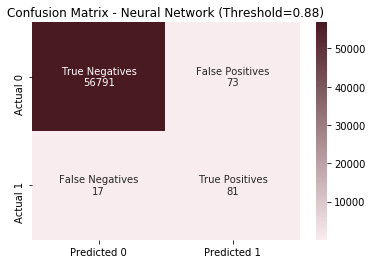

In [20]:
# Define the neural network model
nn = Sequential([
    Dense(64, activation='relu', input_shape=(X_resampled_df.shape[1],)),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

nn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Fit the model on the training data
nn.fit(X_resampled_df, y_resampled, epochs=20, batch_size=32)

# Evaluate the model on the test set
y_pred_prob_nn = nn.predict(X_test_df).flatten()  # Predict probabilities
y_pred_nn = (y_pred_prob_nn > threshold).astype(int)  # Convert probabilities to binary predictions

# Compute performance metrics
mcc_nn = matthews_corrcoef(y_test, y_pred_nn)
print(f"Neural Network - Matthews Correlation Coefficient: {mcc_nn:.4f}")

# Print classification report
print("\nClassification Report of Neural Network:\n")
print(classification_report(y_test, y_pred_nn))

# Plot Confusion Matrix
plot_confusion_matrix(y_test, y_pred_nn, 'Neural Network', threshold)


### Smote

Class distribution before RandomUnderSampler:
Counter({0: 227451, 1: 394})

Class distribution after SMOTE:
Counter({0: 227451, 1: 227451}) 


Algorithm: Random Forest 

Matthews Correlation Coefficient: 0.8517

Classification Report of Random Forest : 

             precision    recall  f1-score   support

          0       1.00      1.00      1.00     56864
          1       0.96      0.76      0.85        98

avg / total       1.00      1.00      1.00     56962



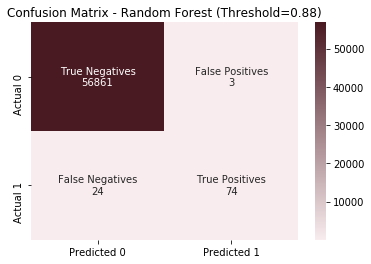


Algorithm: Logistic Regression 

Matthews Correlation Coefficient: 0.7834

Classification Report of Logistic Regression : 

             precision    recall  f1-score   support

          0       1.00      1.00      1.00     56864
          1       0.71      0.87      0.78        98

avg / total       1.00      1.00      1.00     56962



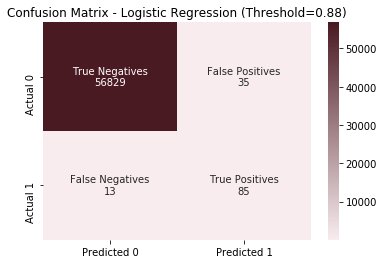


Algorithm: XGBoost 

Matthews Correlation Coefficient: 0.7626

Classification Report of XGBoost : 

             precision    recall  f1-score   support

          0       1.00      1.00      1.00     56864
          1       0.70      0.83      0.76        98

avg / total       1.00      1.00      1.00     56962



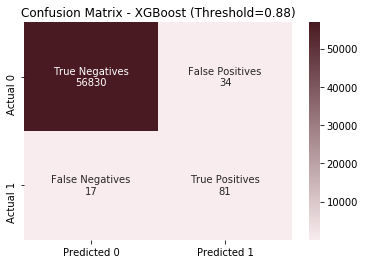


Algorithm: AdaBoost 

Matthews Correlation Coefficient: 0.6523

Classification Report of AdaBoost : 

             precision    recall  f1-score   support

          0       1.00      1.00      1.00     56864
          1       0.52      0.83      0.64        98

avg / total       1.00      1.00      1.00     56962



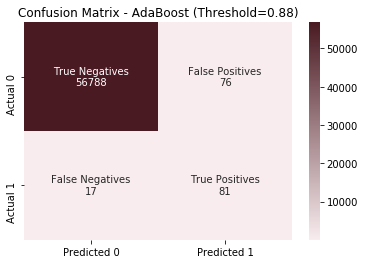


Algorithm: LightGBM 

Matthews Correlation Coefficient: 0.8179

Classification Report of LightGBM : 

             precision    recall  f1-score   support

          0       1.00      1.00      1.00     56864
          1       0.79      0.85      0.82        98

avg / total       1.00      1.00      1.00     56962



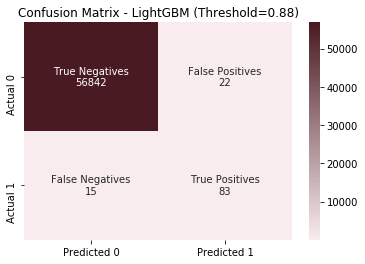

In [21]:
# Calculate class distribution before random under-sampling
print("Class distribution before RandomUnderSampler:")
print(Counter(y_train))

# Initialize RandomUnderSampler and apply it to the training data
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Calculate class distribution after random under-sampling
print("\nClass distribution after SMOTE:")
print(Counter(y_resampled), '\n')

# Ensure the columns in X_test are aligned with the columns used for training
X_resampled_df = pd.DataFrame(X_resampled, columns=X_train.columns)
X_test_df = pd.DataFrame(X_test, columns=X_train.columns)

# Train and evaluate the models on the test set
for name, model in classifiers.items():
    print("\nAlgorithm:", name, '\n')
    
    # Fit the model on the entire training data after resampling
    model.fit(X_resampled_df, y_resampled)
    
    # Predict probabilities instead of classes
    y_pred_prob = model.predict_proba(X_test_df)[:, 1]  # Probabilities of positive class (fraud)

    # Adjust the threshold for binary classification
    threshold = 0.88  # Example threshold, you can change this
    y_pred = (y_pred_prob > threshold).astype(int)  # Convert probabilities to binary predictions
    
    # Compute performance metrics with the adjusted threshold
    mcc = matthews_corrcoef(y_test, y_pred)
    print(f"Matthews Correlation Coefficient: {mcc:.4f}")

    print("\nClassification Report of", name, ":", "\n")
    print(classification_report(y_test, y_pred))

    plot_confusion_matrix(y_test, y_pred, name, threshold)

Epoch 1/20
454902/454902 [==============================] - 27s 60us/step - loss: 0.0922 - acc: 0.9640
Epoch 2/20
454902/454902 [==============================] - 26s 57us/step - loss: 0.0464 - acc: 0.9833
Epoch 3/20
454902/454902 [==============================] - 25s 55us/step - loss: 0.0404 - acc: 0.9857
Epoch 4/20
454902/454902 [==============================] - 25s 55us/step - loss: 0.0377 - acc: 0.9871
Epoch 5/20
454902/454902 [==============================] - 25s 55us/step - loss: 0.0357 - acc: 0.9880
Epoch 6/20
454902/454902 [==============================] - 26s 56us/step - loss: 0.0334 - acc: 0.9889
Epoch 7/20
454902/454902 [==============================] - 27s 60us/step - loss: 0.0329 - acc: 0.9893
Epoch 8/20
454902/454902 [==============================] - 27s 60us/step - loss: 0.0317 - acc: 0.9896
Epoch 9/20
454902/454902 [==============================] - 28s 62us/step - loss: 0.0310 - acc: 0.9898
Epoch 10/20
454902/454902 [==============================] - 30s 66us/ste

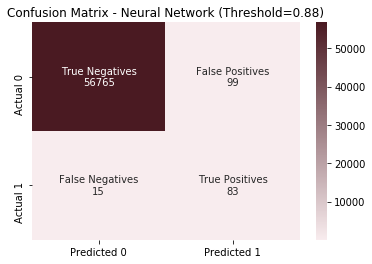

In [22]:
# Define the neural network model
nn = Sequential([
    Dense(64, activation='relu', input_shape=(X_resampled_df.shape[1],)),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

nn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Fit the model on the training data
nn.fit(X_resampled_df, y_resampled, epochs=20, batch_size=32)

# Evaluate the model on the test set
y_pred_prob_nn = nn.predict(X_test_df).flatten()  # Predict probabilities
y_pred_nn = (y_pred_prob_nn > threshold).astype(int)  # Convert probabilities to binary predictions

# Compute performance metrics
mcc_nn = matthews_corrcoef(y_test, y_pred_nn)
print(f"Neural Network - Matthews Correlation Coefficient: {mcc_nn:.4f}")

# Print classification report
print("\nClassification Report of Neural Network:\n")
print(classification_report(y_test, y_pred_nn))

# Plot Confusion Matrix
plot_confusion_matrix(y_test, y_pred_nn, 'Neural Network', threshold)

### RUS + ROS

Class distribution before RandomUnderSampler:
Counter({0: 227451, 1: 394})

Class distribution after RandomUnderSampler:
Counter({0: 4804, 1: 394}) 


Class distribution after RandomOverSampler:
Counter({0: 4804, 1: 2930}) 


Algorithm: Random Forest 

Matthews Correlation Coefficient: 0.7981

Classification Report of Random Forest : 

             precision    recall  f1-score   support

          0       1.00      1.00      1.00     56864
          1       0.77      0.83      0.80        98

avg / total       1.00      1.00      1.00     56962



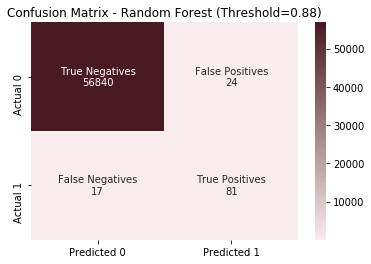


Algorithm: Logistic Regression 

Matthews Correlation Coefficient: 0.7919

Classification Report of Logistic Regression : 

             precision    recall  f1-score   support

          0       1.00      1.00      1.00     56864
          1       0.74      0.85      0.79        98

avg / total       1.00      1.00      1.00     56962



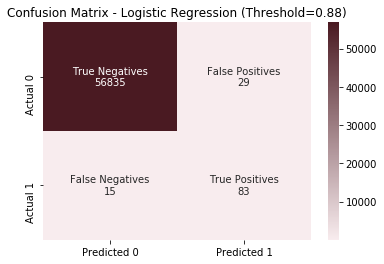


Algorithm: XGBoost 

Matthews Correlation Coefficient: 0.8038

Classification Report of XGBoost : 

             precision    recall  f1-score   support

          0       1.00      1.00      1.00     56864
          1       0.75      0.87      0.80        98

avg / total       1.00      1.00      1.00     56962



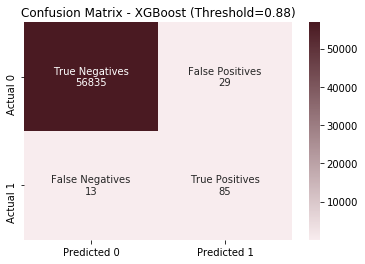


Algorithm: AdaBoost 

Matthews Correlation Coefficient: 0.7758

Classification Report of AdaBoost : 

             precision    recall  f1-score   support

          0       1.00      1.00      1.00     56864
          1       0.84      0.71      0.77        98

avg / total       1.00      1.00      1.00     56962



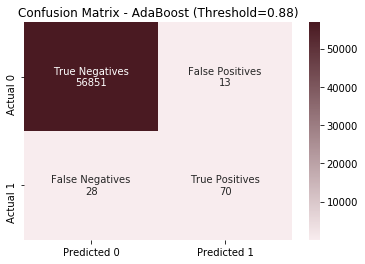


Algorithm: LightGBM 

Matthews Correlation Coefficient: 0.8110

Classification Report of LightGBM : 

             precision    recall  f1-score   support

          0       1.00      1.00      1.00     56864
          1       0.76      0.87      0.81        98

avg / total       1.00      1.00      1.00     56962



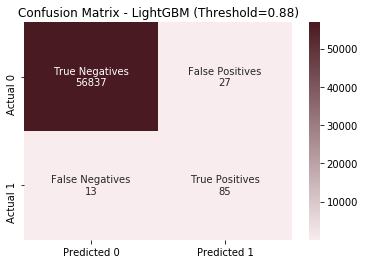

In [55]:
# Calculate class distribution before random under-sampling
print("Class distribution before RandomUnderSampler:")
print(Counter(y_train))

# Initialize RandomUnderSampler and apply it to the training data
rus = RandomUnderSampler(sampling_strategy=0.082)
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

# Calculate class distribution after random under-sampling
print("\nClass distribution after RandomUnderSampler:")
print(Counter(y_resampled), '\n')

# Initialize SMOTE and apply it to the resampled data
ros = RandomOverSampler(sampling_strategy=0.61)
X_resampled, y_resampled = ros.fit_resample(X_resampled, y_resampled)

print("\nClass distribution after RandomOverSampler:")
print(Counter(y_resampled), '\n')

# Ensure the columns in X_test are aligned with the columns used for training
X_resampled_df = pd.DataFrame(X_resampled, columns=X_train.columns)
X_test_df = pd.DataFrame(X_test, columns=X_train.columns)

# Train and evaluate the models on the test set
for name, model in classifiers.items():
    print("\nAlgorithm:", name, '\n')
    
    # Fit the model on the entire training data after resampling
    model.fit(X_resampled_df, y_resampled)
    
    # Predict probabilities instead of classes
    y_pred_prob = model.predict_proba(X_test_df)[:, 1]  # Probabilities of positive class (fraud)

    # Adjust the threshold for binary classification
    threshold = 0.88  # Example threshold, you can change this
    y_pred = (y_pred_prob > threshold).astype(int)  # Convert probabilities to binary predictions
    
    # Compute performance metrics with the adjusted threshold
    mcc = matthews_corrcoef(y_test, y_pred)
    print(f"Matthews Correlation Coefficient: {mcc:.4f}")

    print("\nClassification Report of", name, ":", "\n")
    print(classification_report(y_test, y_pred))

    plot_confusion_matrix(y_test, y_pred, name, threshold)

Epoch 1/20
7734/7734 [==============================] - 2s 318us/step - loss: 0.4332 - acc: 0.8300
Epoch 2/20
7734/7734 [==============================] - 1s 78us/step - loss: 0.2372 - acc: 0.9260
Epoch 3/20
7734/7734 [==============================] - 1s 92us/step - loss: 0.2002 - acc: 0.9383
Epoch 4/20
7734/7734 [==============================] - 1s 74us/step - loss: 0.1858 - acc: 0.9392
Epoch 5/20
7734/7734 [==============================] - 1s 73us/step - loss: 0.1698 - acc: 0.9431
Epoch 6/20
7734/7734 [==============================] - 1s 72us/step - loss: 0.1596 - acc: 0.9450
Epoch 7/20
7734/7734 [==============================] - 1s 82us/step - loss: 0.1464 - acc: 0.9463
Epoch 8/20
7734/7734 [==============================] - 0s 63us/step - loss: 0.1369 - acc: 0.9484
Epoch 9/20
7734/7734 [==============================] - 0s 63us/step - loss: 0.1383 - acc: 0.9483
Epoch 10/20
7734/7734 [==============================] - 0s 65us/step - loss: 0.1311 - acc: 0.9454
Epoch 11/20
7734/7

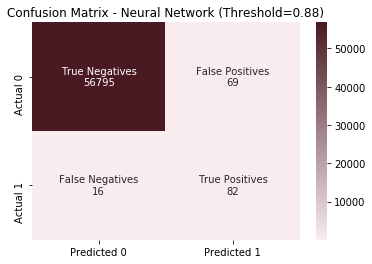

In [56]:
# Define the neural network model
nn = Sequential([
    Dense(64, activation='relu', input_shape=(X_resampled_df.shape[1],)),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

nn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Fit the model on the training data
nn.fit(X_resampled_df, y_resampled, epochs=20, batch_size=32)

# Evaluate the model on the test set
y_pred_prob_nn = nn.predict(X_test_df).flatten()  # Predict probabilities
y_pred_nn = (y_pred_prob_nn > threshold).astype(int)  # Convert probabilities to binary predictions

# Compute performance metrics
mcc_nn = matthews_corrcoef(y_test, y_pred_nn)
print(f"Neural Network - Matthews Correlation Coefficient: {mcc_nn:.4f}")

# Print classification report
print("\nClassification Report of Neural Network:\n")
print(classification_report(y_test, y_pred_nn))

# Plot Confusion Matrix
plot_confusion_matrix(y_test, y_pred_nn, 'Neural Network', threshold)


### RUS + SMOTE

Class distribution before RandomUnderSampler:
Counter({0: 227451, 1: 394})

Class distribution after RandomUnderSampler:
Counter({0: 4804, 1: 394}) 


Class distribution after SMOTE:
Counter({0: 4804, 1: 2930}) 


Algorithm: Random Forest 

Matthews Correlation Coefficient: 0.7615

Classification Report of Random Forest : 

             precision    recall  f1-score   support

          0       1.00      1.00      1.00     56864
          1       0.68      0.86      0.76        98

avg / total       1.00      1.00      1.00     56962



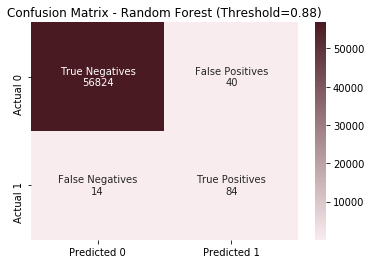


Algorithm: Logistic Regression 

Matthews Correlation Coefficient: 0.8119

Classification Report of Logistic Regression : 

             precision    recall  f1-score   support

          0       1.00      1.00      1.00     56864
          1       0.79      0.84      0.81        98

avg / total       1.00      1.00      1.00     56962



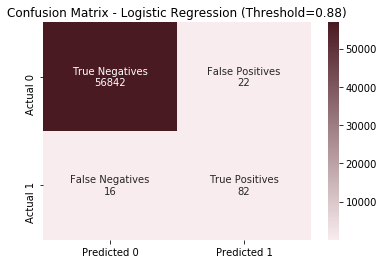


Algorithm: XGBoost 

Matthews Correlation Coefficient: 0.7906

Classification Report of XGBoost : 

             precision    recall  f1-score   support

          0       1.00      1.00      1.00     56864
          1       0.76      0.83      0.79        98

avg / total       1.00      1.00      1.00     56962



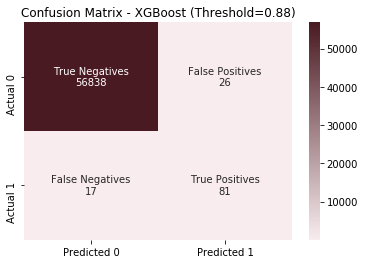


Algorithm: AdaBoost 

Matthews Correlation Coefficient: 0.8196

Classification Report of AdaBoost : 

             precision    recall  f1-score   support

          0       1.00      1.00      1.00     56864
          1       0.86      0.79      0.82        98

avg / total       1.00      1.00      1.00     56962



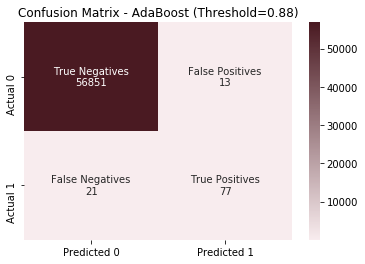


Algorithm: LightGBM 

Matthews Correlation Coefficient: 0.8381

Classification Report of LightGBM : 

             precision    recall  f1-score   support

          0       1.00      1.00      1.00     56864
          1       0.83      0.85      0.84        98

avg / total       1.00      1.00      1.00     56962



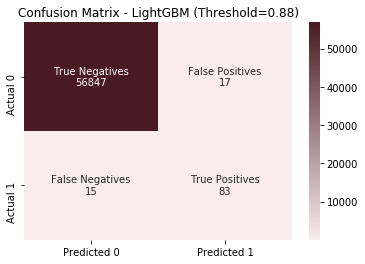

In [57]:
# Calculate class distribution before random under-sampling
print("Class distribution before RandomUnderSampler:")
print(Counter(y_train))

# Initialize RandomUnderSampler and apply it to the training data
rus = RandomUnderSampler(sampling_strategy=0.082)
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

# Calculate class distribution after random under-sampling
print("\nClass distribution after RandomUnderSampler:")
print(Counter(y_resampled), '\n')

# Initialize SMOTE and apply it to the resampled data
smote = SMOTE(sampling_strategy=0.61)
X_resampled, y_resampled = smote.fit_resample(X_resampled, y_resampled)

print("\nClass distribution after SMOTE:")
print(Counter(y_resampled), '\n')

# Ensure the columns in X_test are aligned with the columns used for training
X_resampled_df = pd.DataFrame(X_resampled, columns=X_train.columns)
X_test_df = pd.DataFrame(X_test, columns=X_train.columns)

# Train and evaluate the models on the test set
for name, model in classifiers.items():
    print("\nAlgorithm:", name, '\n')
    
    # Fit the model on the entire training data after resampling
    model.fit(X_resampled_df, y_resampled)
    
    # Predict probabilities instead of classes
    y_pred_prob = model.predict_proba(X_test_df)[:, 1]  # Probabilities of positive class (fraud)

    # Adjust the threshold for binary classification
    threshold = 0.88  # Example threshold, you can change this
    y_pred = (y_pred_prob > threshold).astype(int)  # Convert probabilities to binary predictions
    
    # Compute performance metrics with the adjusted threshold
    mcc = matthews_corrcoef(y_test, y_pred)
    print(f"Matthews Correlation Coefficient: {mcc:.4f}")

    print("\nClassification Report of", name, ":", "\n")
    print(classification_report(y_test, y_pred))

    plot_confusion_matrix(y_test, y_pred, name, threshold)

Epoch 1/20
7734/7734 [==============================] - 2s 322us/step - loss: 0.5886 - acc: 0.8207
Epoch 2/20
7734/7734 [==============================] - 0s 64us/step - loss: 0.2523 - acc: 0.9163
Epoch 3/20
7734/7734 [==============================] - 1s 81us/step - loss: 0.2089 - acc: 0.9347
Epoch 4/20
7734/7734 [==============================] - 1s 73us/step - loss: 0.1868 - acc: 0.9413
Epoch 5/20
7734/7734 [==============================] - 1s 84us/step - loss: 0.1772 - acc: 0.9410
Epoch 6/20
7734/7734 [==============================] - 1s 80us/step - loss: 0.1602 - acc: 0.9452
Epoch 7/20
7734/7734 [==============================] - 1s 76us/step - loss: 0.1550 - acc: 0.9450
Epoch 8/20
7734/7734 [==============================] - 1s 75us/step - loss: 0.1424 - acc: 0.9463
Epoch 9/20
7734/7734 [==============================] - 1s 80us/step - loss: 0.1391 - acc: 0.9506
Epoch 10/20
7734/7734 [==============================] - 1s 89us/step - loss: 0.1243 - acc: 0.9515
Epoch 11/20
7734/7

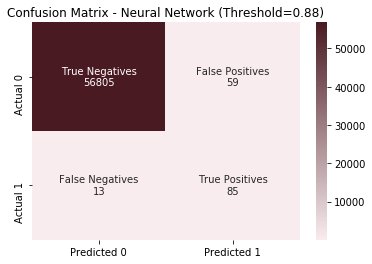

In [58]:
# Define the neural network model
nn = Sequential([
    Dense(64, activation='relu', input_shape=(X_resampled_df.shape[1],)),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

nn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Fit the model on the training data
nn.fit(X_resampled_df, y_resampled, epochs=20, batch_size=32)

# Evaluate the model on the test set
y_pred_prob_nn = nn.predict(X_test_df).flatten()  # Predict probabilities
y_pred_nn = (y_pred_prob_nn > threshold).astype(int)  # Convert probabilities to binary predictions

# Compute performance metrics
mcc_nn = matthews_corrcoef(y_test, y_pred_nn)
print(f"Neural Network - Matthews Correlation Coefficient: {mcc_nn:.4f}")

# Print classification report
print("\nClassification Report of Neural Network:\n")
print(classification_report(y_test, y_pred_nn))

# Plot Confusion Matrix
plot_confusion_matrix(y_test, y_pred_nn, 'Neural Network', threshold)


### RUS + SMOTE Tomek

Class distribution before RandomUnderSampler:
Counter({0: 227451, 1: 394})

Class distribution after RandomUnderSampler:
Counter({0: 4804, 1: 394}) 


Class distribution after SMOTE Tomek:
Counter({0: 4801, 1: 2927}) 


Algorithm: Random Forest 

Matthews Correlation Coefficient: 0.7645

Classification Report of Random Forest : 

             precision    recall  f1-score   support

          0       1.00      1.00      1.00     56864
          1       0.67      0.87      0.76        98

avg / total       1.00      1.00      1.00     56962



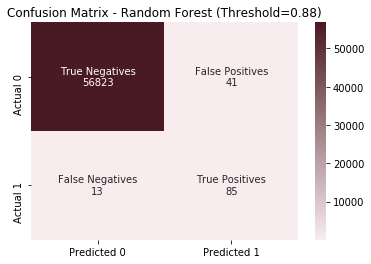


Algorithm: Logistic Regression 

Matthews Correlation Coefficient: 0.8020

Classification Report of Logistic Regression : 

             precision    recall  f1-score   support

          0       1.00      1.00      1.00     56864
          1       0.78      0.83      0.80        98

avg / total       1.00      1.00      1.00     56962



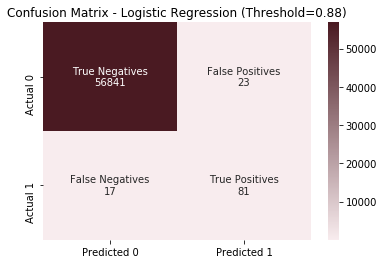


Algorithm: XGBoost 

Matthews Correlation Coefficient: 0.7736

Classification Report of XGBoost : 

             precision    recall  f1-score   support

          0       1.00      1.00      1.00     56864
          1       0.73      0.82      0.77        98

avg / total       1.00      1.00      1.00     56962



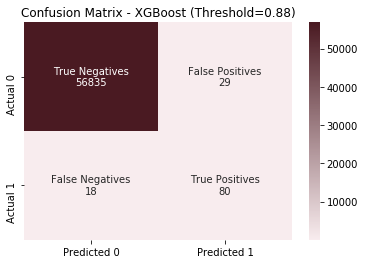


Algorithm: AdaBoost 

Matthews Correlation Coefficient: 0.8317

Classification Report of AdaBoost : 

             precision    recall  f1-score   support

          0       1.00      1.00      1.00     56864
          1       0.86      0.81      0.83        98

avg / total       1.00      1.00      1.00     56962



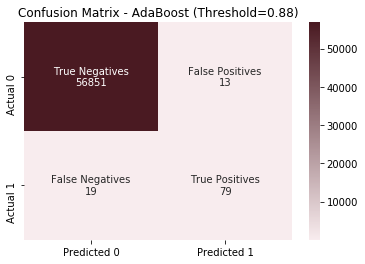


Algorithm: LightGBM 

Matthews Correlation Coefficient: 0.8059

Classification Report of LightGBM : 

             precision    recall  f1-score   support

          0       1.00      1.00      1.00     56864
          1       0.79      0.83      0.81        98

avg / total       1.00      1.00      1.00     56962



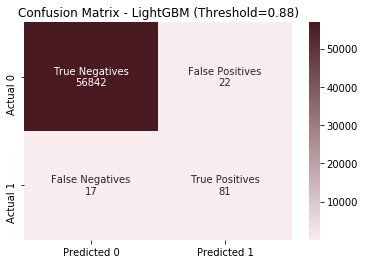

In [59]:
# Calculate class distribution before random under-sampling
print("Class distribution before RandomUnderSampler:")
print(Counter(y_train))

# Initialize RandomUnderSampler and apply it to the training data
rus = RandomUnderSampler(sampling_strategy=0.082)
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

# Calculate class distribution after random under-sampling
print("\nClass distribution after RandomUnderSampler:")
print(Counter(y_resampled), '\n')

# Initialize SMOTE and apply it to the resampled data
smotetomek = SMOTETomek(sampling_strategy=0.61)
X_resampled, y_resampled = smotetomek.fit_resample(X_resampled, y_resampled)

print("\nClass distribution after SMOTE Tomek:")
print(Counter(y_resampled), '\n')

# Ensure the columns in X_test are aligned with the columns used for training
X_resampled_df = pd.DataFrame(X_resampled, columns=X_train.columns)
X_test_df = pd.DataFrame(X_test, columns=X_train.columns)

# Train and evaluate the models on the test set
for name, model in classifiers.items():
    print("\nAlgorithm:", name, '\n')
    
    # Fit the model on the entire training data after resampling
    model.fit(X_resampled_df, y_resampled)
    
    # Predict probabilities instead of classes
    y_pred_prob = model.predict_proba(X_test_df)[:, 1]  # Probabilities of positive class (fraud)

    # Adjust the threshold for binary classification
    threshold = 0.88  # Example threshold, you can change this
    y_pred = (y_pred_prob > threshold).astype(int)  # Convert probabilities to binary predictions
    
    # Compute performance metrics with the adjusted threshold
    mcc = matthews_corrcoef(y_test, y_pred)
    print(f"Matthews Correlation Coefficient: {mcc:.4f}")

    print("\nClassification Report of", name, ":", "\n")
    print(classification_report(y_test, y_pred))
    
    plot_confusion_matrix(y_test, y_pred, name, threshold)

Epoch 1/20
7728/7728 [==============================] - 3s 348us/step - loss: 0.5576 - acc: 0.8077
Epoch 2/20
7728/7728 [==============================] - 1s 80us/step - loss: 0.2345 - acc: 0.9202
Epoch 3/20
7728/7728 [==============================] - 1s 79us/step - loss: 0.2038 - acc: 0.9341
Epoch 4/20
7728/7728 [==============================] - 1s 103us/step - loss: 0.1866 - acc: 0.9420
Epoch 5/20
7728/7728 [==============================] - 1s 92us/step - loss: 0.1691 - acc: 0.9440
Epoch 6/20
7728/7728 [==============================] - 1s 91us/step - loss: 0.1549 - acc: 0.9472
Epoch 7/20
7728/7728 [==============================] - 1s 78us/step - loss: 0.1473 - acc: 0.9489
Epoch 8/20
7728/7728 [==============================] - 1s 69us/step - loss: 0.1384 - acc: 0.9460
Epoch 9/20
7728/7728 [==============================] - 1s 89us/step - loss: 0.1329 - acc: 0.9494
Epoch 10/20
7728/7728 [==============================] - 1s 78us/step - loss: 0.1251 - acc: 0.9532
Epoch 11/20
7728/

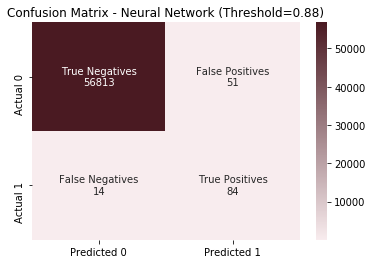

In [60]:
# Define the neural network model
nn = Sequential([
    Dense(64, activation='relu', input_shape=(X_resampled_df.shape[1],)),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

nn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Fit the model on the training data
nn.fit(X_resampled_df, y_resampled, epochs=20, batch_size=32)

# Evaluate the model on the test set
y_pred_prob_nn = nn.predict(X_test_df).flatten()  # Predict probabilities
y_pred_nn = (y_pred_prob_nn > threshold).astype(int)  # Convert probabilities to binary predictions

# Compute performance metrics
mcc_nn = matthews_corrcoef(y_test, y_pred_nn)
print(f"Neural Network - Matthews Correlation Coefficient: {mcc_nn:.4f}")

# Print classification report
print("\nClassification Report of Neural Network:\n")
print(classification_report(y_test, y_pred_nn))

# Plot Confusion Matrix
plot_confusion_matrix(y_test, y_pred_nn, 'Neural Network', threshold)


### RUS + SMOTE ENN

Class distribution before RandomUnderSampler:
Counter({0: 227451, 1: 394})

Class distribution after RandomUnderSampler:
Counter({0: 4804, 1: 394}) 


Class distribution after SMOTE ENN:
Counter({0: 4569, 1: 2897}) 


Algorithm: Random Forest 

Matthews Correlation Coefficient: 0.6522

Classification Report of Random Forest : 

             precision    recall  f1-score   support

          0       1.00      1.00      1.00     56864
          1       0.49      0.88      0.63        98

avg / total       1.00      1.00      1.00     56962



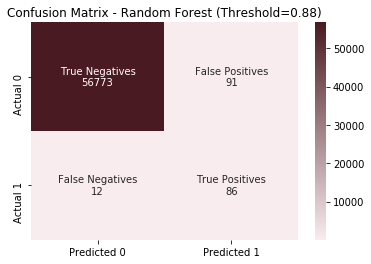


Algorithm: Logistic Regression 

Matthews Correlation Coefficient: 0.6760

Classification Report of Logistic Regression : 

             precision    recall  f1-score   support

          0       1.00      1.00      1.00     56864
          1       0.53      0.87      0.66        98

avg / total       1.00      1.00      1.00     56962



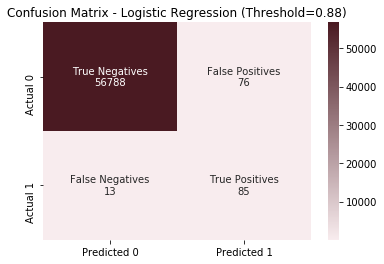


Algorithm: XGBoost 

Matthews Correlation Coefficient: 0.5554

Classification Report of XGBoost : 

             precision    recall  f1-score   support

          0       1.00      1.00      1.00     56864
          1       0.37      0.85      0.51        98

avg / total       1.00      1.00      1.00     56962



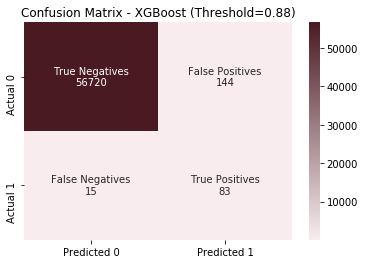


Algorithm: AdaBoost 

Matthews Correlation Coefficient: 0.6381

Classification Report of AdaBoost : 

             precision    recall  f1-score   support

          0       1.00      1.00      1.00     56864
          1       0.50      0.82      0.62        98

avg / total       1.00      1.00      1.00     56962



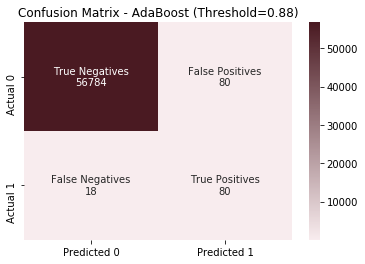


Algorithm: LightGBM 

Matthews Correlation Coefficient: 0.7841

Classification Report of LightGBM : 

             precision    recall  f1-score   support

          0       1.00      1.00      1.00     56864
          1       0.72      0.86      0.78        98

avg / total       1.00      1.00      1.00     56962



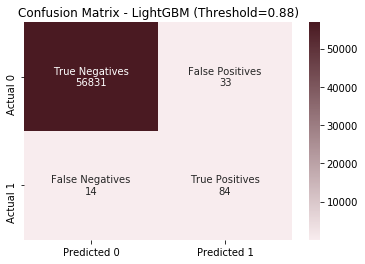

In [61]:
# Calculate class distribution before random under-sampling
print("Class distribution before RandomUnderSampler:")
print(Counter(y_train))

# Initialize RandomUnderSampler and apply it to the training data
rus = RandomUnderSampler(sampling_strategy=0.082)
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

# Calculate class distribution after random under-sampling
print("\nClass distribution after RandomUnderSampler:")
print(Counter(y_resampled), '\n')

# Initialize SMOTE and apply it to the resampled data
smoteenn = SMOTEENN(sampling_strategy=0.61)
X_resampled, y_resampled = smoteenn.fit_resample(X_resampled, y_resampled)

print("\nClass distribution after SMOTE ENN:")
print(Counter(y_resampled), '\n')

# Ensure the columns in X_test are aligned with the columns used for training
X_resampled_df = pd.DataFrame(X_resampled, columns=X_train.columns)
X_test_df = pd.DataFrame(X_test, columns=X_train.columns)

# Train and evaluate the models on the test set
for name, model in classifiers.items():
    print("\nAlgorithm:", name, '\n')
    
    # Fit the model on the entire training data after resampling
    model.fit(X_resampled_df, y_resampled)
    
    # Predict probabilities instead of classes
    y_pred_prob = model.predict_proba(X_test_df)[:, 1]  # Probabilities of positive class (fraud)

    # Adjust the threshold for binary classification
    threshold = 0.88  # Example threshold, you can change this
    y_pred = (y_pred_prob > threshold).astype(int)  # Convert probabilities to binary predictions
    
    # Compute performance metrics with the adjusted threshold
    mcc = matthews_corrcoef(y_test, y_pred)
    print(f"Matthews Correlation Coefficient: {mcc:.4f}")

    print("\nClassification Report of", name, ":", "\n")
    print(classification_report(y_test, y_pred))

    plot_confusion_matrix(y_test, y_pred, name, threshold)

Epoch 1/20
7466/7466 [==============================] - 3s 354us/step - loss: 0.4503 - acc: 0.8480
Epoch 2/20
7466/7466 [==============================] - 1s 79us/step - loss: 0.2375 - acc: 0.9273
Epoch 3/20
7466/7466 [==============================] - 1s 73us/step - loss: 0.1965 - acc: 0.9395
Epoch 4/20
7466/7466 [==============================] - 1s 81us/step - loss: 0.1717 - acc: 0.9464
Epoch 5/20
7466/7466 [==============================] - 1s 88us/step - loss: 0.1576 - acc: 0.9460
Epoch 6/20
7466/7466 [==============================] - 1s 86us/step - loss: 0.1440 - acc: 0.9478
Epoch 7/20
7466/7466 [==============================] - 1s 94us/step - loss: 0.1334 - acc: 0.9496
Epoch 8/20
7466/7466 [==============================] - 1s 81us/step - loss: 0.1266 - acc: 0.9507
Epoch 9/20
7466/7466 [==============================] - 1s 88us/step - loss: 0.1193 - acc: 0.9522
Epoch 10/20
7466/7466 [==============================] - 1s 89us/step - loss: 0.1128 - acc: 0.9529
Epoch 11/20
7466/7

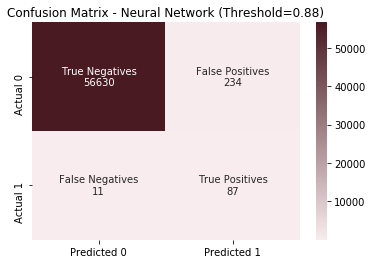

In [62]:
# Define the neural network model
nn = Sequential([
    Dense(64, activation='relu', input_shape=(X_resampled_df.shape[1],)),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

nn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Fit the model on the training data
nn.fit(X_resampled_df, y_resampled, epochs=20, batch_size=32)

# Evaluate the model on the test set
y_pred_prob_nn = nn.predict(X_test_df).flatten()  # Predict probabilities
y_pred_nn = (y_pred_prob_nn > threshold).astype(int)  # Convert probabilities to binary predictions

# Compute performance metrics
mcc_nn = matthews_corrcoef(y_test, y_pred_nn)
print(f"Neural Network - Matthews Correlation Coefficient: {mcc_nn:.4f}")

# Print classification report
print("\nClassification Report of Neural Network:\n")
print(classification_report(y_test, y_pred_nn))

# Plot Confusion Matrix
plot_confusion_matrix(y_test, y_pred_nn, 'Neural Network', threshold)


# Hyperparameter optimization

In [123]:
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, confusion_matrix, matthews_corrcoef
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from collections import Counter

# Define the LightGBM classifier
lgbm = LGBMClassifier(random_state=42)

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'num_leaves': [31, 50, 100],
    'learning_rate': [0.1, 0.01],
    'max_depth': [5, 10, 15],
    'min_child_samples': [10, 20, 30],
}

# Calculate class distribution before random under-sampling
print("Class distribution before RandomUnderSampler:")
print(Counter(y_train))

# Initialize RandomUnderSampler and apply it to the training data
rus = RandomUnderSampler(sampling_strategy=0.082)
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

# Calculate class distribution after random under-sampling
print("\nClass distribution after RandomUnderSampler:")
print(Counter(y_resampled), '\n')

# Initialize SMOTE and apply it to the resampled data
smote = SMOTE(sampling_strategy=0.61)
X_resampled, y_resampled = smote.fit_resample(X_resampled, y_resampled)

print("\nClass distribution after SMOTE:")
print(Counter(y_resampled), '\n')

# Ensure the columns in X_test are aligned with the columns used for training
X_resampled_df = pd.DataFrame(X_resampled, columns=X_train.columns)
X_test_df = pd.DataFrame(X_test, columns=X_train.columns)

# Initialize GridSearchCV with the classifier, parameter grid, and scoring metric
grid_search = GridSearchCV(lgbm, param_grid, scoring='precision', cv=5)

# Fit GridSearchCV to the resampled training data
grid_search.fit(X_resampled_df, y_resampled)

# Get the best estimator from GridSearchCV
best_estimator = grid_search.best_estimator_

# Print the best hyperparameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Class distribution before RandomUnderSampler:
Counter({0: 227451, 1: 394})

Class distribution after RandomUnderSampler:
Counter({0: 4804, 1: 394}) 


Class distribution after SMOTE:
Counter({0: 4804, 1: 2930}) 

Best Parameters: {'learning_rate': 0.01, 'max_depth': 5, 'min_child_samples': 30, 'n_estimators': 30, 'num_leaves': 31}
Best Score: 0.9949472875087177


Class distribution before RandomUnderSampler:
Counter({0: 227451, 1: 394})

Class distribution after RandomUnderSampler:
Counter({0: 4804, 1: 394}) 


Class distribution after SMOTE:
Counter({0: 4804, 1: 2930}) 


Algorithm: LightGBM 

Matthews Correlation Coefficient: 0.8541

Classification Report of LightGBM : 

             precision    recall  f1-score   support

          0       1.00      1.00      1.00     56864
          1       0.87      0.84      0.85        98

avg / total       1.00      1.00      1.00     56962



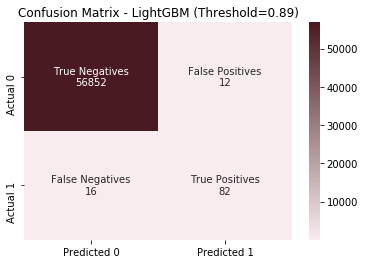

In [137]:
classifiers = {
    "LightGBM": LGBMClassifier(learning_rate=0.1, max_depth=5, n_estimators=30, random_state=42, min_child_samples = 30, num_leaves = 31, class_weight={0: 0.75, 1: 0.25}),
}

# Calculate class distribution before random under-sampling
print("Class distribution before RandomUnderSampler:")
print(Counter(y_train))

# Initialize RandomUnderSampler and apply it to the training data
rus = RandomUnderSampler(sampling_strategy=0.082)
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

# Calculate class distribution after random under-sampling
print("\nClass distribution after RandomUnderSampler:")
print(Counter(y_resampled), '\n')

# Initialize SMOTE and apply it to the resampled data
smote = SMOTE(sampling_strategy=0.61)
X_resampled, y_resampled = smote.fit_resample(X_resampled, y_resampled)

print("\nClass distribution after SMOTE:")
print(Counter(y_resampled), '\n')

# Ensure the columns in X_test are aligned with the columns used for training
X_resampled_df = pd.DataFrame(X_resampled, columns=X_train.columns)
X_test_df = pd.DataFrame(X_test, columns=X_train.columns)

# Train and evaluate the models on the test set
for name, model in classifiers.items():
    print("\nAlgorithm:", name, '\n')
    
    # Fit the model on the entire training data after resampling
    model.fit(X_resampled_df, y_resampled)
    
    # Predict probabilities instead of classes
    y_pred_prob = model.predict_proba(X_test_df)[:, 1]  # Probabilities of positive class (fraud)

    # Adjust the threshold for binary classification
    threshold = 0.89  # Example threshold, you can change this
    y_pred = (y_pred_prob > threshold).astype(int)  # Convert probabilities to binary predictions
    
    # Compute performance metrics with the adjusted threshold
    mcc = matthews_corrcoef(y_test, y_pred)
    print(f"Matthews Correlation Coefficient: {mcc:.4f}")

    print("\nClassification Report of", name, ":", "\n")
    print(classification_report(y_test, y_pred))

    plot_confusion_matrix(y_test, y_pred, name, threshold)